# Pricing using Diffusion Models & Numerical Methods

## Introduction  
This notebook explores quantitative finance techniques for pricing derivatives using stochastic processes and numerical methods. We implement several fundamental approaches for modeling asset price dynamics and computing option prices in a Black-Scholes framework.

The notebook serves as both an educational resource and a practical toolkit, demonstrating: theoretical foundations of geometric Brownian motion as a model for asset prices, numerical implementation of key quantitative finance techniques, visualization of financial concepts and simulation results  

## Contents  

#### 1. Brownian Motion Simulation  
- Visualizing fundamental stochastic processes  
- Generating sample paths of Wiener processes  

#### 2. Terminal Price Distribution Analysis  
- Simulation of S<sub>T</sub>  
- Comparing simulation & theoretical distribution  

#### 3. Black-Scholes Analytical Pricing  
- Implementing the classic option pricing formula  
- Visualizing prices

#### 4. Asset Price Trajectory Simulation  
- Simulating trajectories of the asset price under the Black-Scholes model

#### 5. Exotic Option Pricing via Monte Carlo  
- Pricing path-dependent options (Asian and Barrier)  
- Analyzing convergence properties of Monte Carlo methods  

In [1]:
# Imports

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt
import numpy as np

/Users/miller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Brownian Motion Simulation

A **standard Brownian motion** (also called a **Wiener process**) $W_t$ is a continuous–time stochastic process with the following properties:

1. $W_0 = 0$ almost surely.
2. It has **independent increments**: for any $0 \le t_0 < t_1 < \dots < t_n$, the random variables  
   $W_{t_1} - W_{t_0}, \dots, W_{t_n} - W_{t_{n-1}}$ are independent.
3. It has **stationary increments**: the distribution of $W_{t+s} - W_s$ depends only on $t$.
4. For $t > s$, the increment $W_t - W_s$ follows a normal distribution with mean $0$ and variance $t - s$:  
   $$
   W_t - W_s \sim \mathcal{N}(0, \, t - s)
   $$
5. Paths are **almost surely continuous** but nowhere differentiable.

---

### Discretization for Simulation

In practice, we approximate $W_t$ on a discrete time grid $0 = t_0 < t_1 < \dots < t_n = T$ using:

$$
W_{t_{k+1}} = W_{t_k} + \sqrt{\Delta t} \, Z_k
$$

where:
- $\Delta t = \frac{T}{n}$ is the time step,
- $Z_k \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0, 1)$ are independent standard normal variables.

In [2]:
import numpy as np
import random
import math

def brownian_motion(T: float, n_steps: int):
    """
    Generates a single standard Brownian motion path without using advanced NumPy functions.
    """
    dt = T / n_steps
    
    # Time vector
    time = [i * dt for i in range(n_steps + 1)]
    
    # Brownian path
    path = [0.0]
    
    for _ in range(n_steps):
        dW = random.gauss(0, math.sqrt(dt))
        path.append(path[-1] + dW)
    
    return np.array(time), np.array(path)

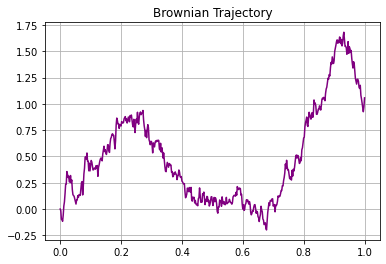

In [3]:
time, path = brownian_motion(T=1, n_steps=500)

plt.plot(time, path, color='purple', linewidth=1.5)
plt.title('Brownian Trajectory')
plt.grid()
plt.show()

## 2. $S_T$ Terminal Price Simulation

In the **Black–Scholes model**, the underlying asset price $S_t$ follows the stochastic differential equation (under the risk–neutral measure $\mathbb{Q}$):

$$
dS_t = r S_t\, dt + \sigma S_t\, dW_t, \quad S_0 > 0
$$

where:
- $r$ is the continuously compounded risk–free interest rate,
- $\sigma > 0$ is the volatility,
- $W_t$ is a standard Brownian motion under $\mathbb{Q}$.

---

### Risk–neutral solution

The SDE has the explicit solution:

$$
S_T = S_0 \exp\left( \left(r - \frac{\sigma^2}{2}\right)T + \sigma W_T \right)
$$

Under $\mathbb{Q}$, $W_T \sim \mathcal{N}(0, T)$, so $\ln S_T$ is normally distributed with:

$$
\ln S_T \sim \mathcal{N}\left( \ln S_0 + \left(r - \frac{\sigma^2}{2}\right)T, \; \sigma^2 T \right)
$$

In [4]:
def black_scholes_ST(S0: float, r: float, sigma: float, T: float, n_paths: int):
    """
    Simulates terminal stock price S_T under the Black-Scholes model

    Parameters:
    -----------
    S0: Starting price
    r: Risk-free rate in the Black-Scholes model
    sigma: Volatility in the Black-Scholes model
    T: Time to maturity
    n_paths: Number of simulated S_T
    
    Returns:
    --------
    Sample of S_T, size = n_paths
        
    Example:
    --------
    black_scholes_ST(S0=100, r=0.05, sigma=0.3, T=1, n_paths=10)
    """
    # W_T ~ N(0, T)
    W_T = np.random.normal(0, np.sqrt(T), size=n_paths)
    
    # Black-Scholes formula for S_T
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
    
    return ST

In [5]:
# Setting parameters to simulate the terminal prices S_T

# Black-Scholes model parameters
sigma = 0.35
r = 0.05

# Initial spot & time horizon
S0 = 100
T = 1.0

# Sample size
n_paths = 5000

# Simulation
ST_samples = black_scholes_ST(S0, r, sigma, T, n_paths)

# Printing first terminal prices at time T
ST_samples[:5]

array([ 97.57887794,  99.01734493,  75.2140139 , 131.09480467,
       121.30694871])

In [6]:
# Computing the theoretical lognormal PDF

shape = sigma * np.sqrt(T)
scale = S0 * np.exp((r - 0.5 * sigma ** 2) * T)

x = np.linspace(min(ST_samples), max(ST_samples), 500)

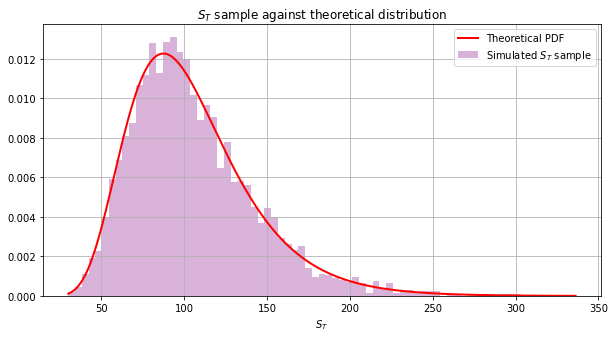

In [21]:
# Plotting empirical histogram & theoretical probability density function
plt.figure(figsize=(10, 5))
plt.hist(ST_samples, color='purple', bins=75, density=True, alpha=0.3, label="Simulated $S_T$ sample")
plt.plot(x, lognorm.pdf(x, s=shape, scale=scale), color='red', lw=2, label="Theoretical PDF")
plt.title("$S_T$ sample against theoretical distribution")
plt.xlabel("$S_T$")
plt.legend()
plt.grid()
plt.show()

## 3. Black-Scholes Analytical Pricing  

### European Call and Put Prices

The **Black–Scholes formulas** for a European call $C$ and put $P$ with strike $K$ and maturity $T$ are:

$$
C(S_0, K, T, r, \sigma) = S_0 \, \Phi(d_1) - K e^{-rT} \, \Phi(d_2)
$$

$$
P(S_0, K, T, r, \sigma) = K e^{-rT} \, \Phi(-d_2) - S_0 \, \Phi(-d_1)
$$

where:

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

and:
- $\Phi(\cdot)$ is the standard normal cumulative distribution function (CDF).

---

### Put–Call Parity

The formulas satisfy **put–call parity**:

$$
C - P = S_0 - K e^{-rT}
$$

In [8]:
def d1(S0: float, K: float, T: float, r: float, sigma: float) -> float:
    """
    Computes the d1 parameter in the Black–Scholes formula
    """
    return (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


def d2(S0: float, K: float, T: float, r: float, sigma: float) -> float:
    """
    Computes the d2 parameter in the Black–Scholes formula
    """
    return d1(S0, K, T, r, sigma) - sigma * np.sqrt(T)


def d(S0: float, K: float, T: float, r: float, sigma: float) -> float:
    """
    Computes both d1 & d2
    """
    return d1(S0, K, T, r, sigma), d2(S0, K, T, r, sigma)

In [9]:
def black_scholes_price(S0: float, K: float, T: float, r: float, sigma: float, option_type: str):
    """
    Pricing a European option under the Black–Scholes model

    Parameters:
    -----------
    S0: Spot price of the underlying asset.
    K: Strike price of the option.
    T: Time to maturity (in years).
    r: Continuously compounded risk–free interest rate.
    sigma: Volatility of the underlying asset.
    option_type: Type of option to price: "call" or "put".

    Returns:
    --------
    float
        Option price according to the Black–Scholes formula.

    Example:
    --------
    black_scholes_price(S0=100, K=105, T=1, r=0.05, sigma=0.2, option_type="call")
    """
    d1, d2 = d(S0, K, T, r, sigma)

    if option_type.lower() == "call":
        return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    elif option_type.lower() == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    else:
        raise ValueError("option_type must be 'call' or 'put'")

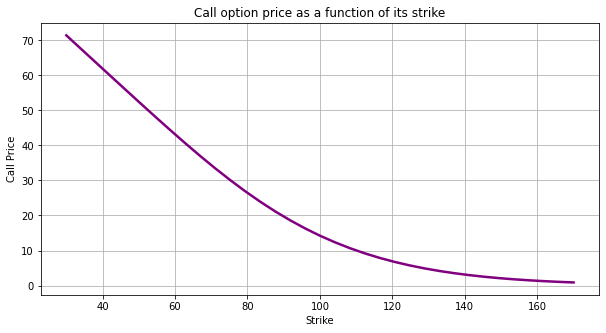

In [10]:
# Choosing strikes & computing prices
strikes = np.linspace(30, 170, 35)
call_prices = [black_scholes_price(S0=100, K=strike, T=1, r=0.05, sigma=0.3, option_type="call") for strike in strikes]

plt.figure(figsize=(10, 5))
plt.plot(strikes, call_prices, lw=2.5, color='purple')
plt.xlabel("Strike")
plt.ylabel("Call Price")
plt.title(f"Call option price as a function of its strike")
plt.grid()
plt.show()

## 4. Asset Price Trajectory Simulation

In this section, we simulate trajectories of the underlying asset price under the **Black–Scholes model**.  

### Stochastic Differential Equation Approximation

To simulate paths numerically, we use the **Euler–Maruyama scheme**, which approximates the SDE over small time steps $\Delta t$:

$$
S_{t+\Delta t} \approx S_t \, \exp\Big( (r - \frac{1}{2} \sigma^2) \Delta t + \sigma \Delta W_t \Big)
$$

where $\Delta W_t \sim \mathcal{N}(0, \Delta t)$ are Gaussian increments.

This approximation scheme comes from discretizing the continuous-time stochastic differential equation. The idea is to replace the infinitesimal changes $dt$ and $dW_t$ by small but finite increments $\Delta t$ and $\Delta W_t$, then propagate the process step by step.

In [11]:
def black_scholes_single_path(S0: float, r: float, sigma: float, T: float, n_steps: int):
    """
    Simulating a single trajectory of the asset price under the Black-Scholes model 
    using a pre-generated Brownian motion.

    Parameters:
    -----------
    S0: Initial price of the underlying asset.
    r: Continuously compounded risk-free interest rate.
    sigma: Volatility of the underlying asset.
    T: Time to maturity.
    n_steps: Number of time steps in the simulation.

    Returns:
    --------
    np.ndarray
        Array of shape (n_steps+1,) containing the simulated asset price path.
        The first element is the initial price S0.
    
    Example:
    --------
    path = black_scholes_single_path(S0=100, r=0.05, sigma=0.2, T=1, n_steps=50)
    """
    # Generating a Brownian motion as a source of randomness driving the asset price trajectory
    time, brownian = brownian_motion(T, n_steps)
    
    # Computing the asset price explicitely from the Brownian
    return S0 * np.exp((r - 0.5 * sigma**2) * time + sigma * brownian)

In [12]:
# Number of steps in each trajectory
n_steps = 50

# Number of trajectories
n_paths = 500

# Simulate paths
paths = np.array([black_scholes_single_path(S0, r, sigma, T, n_steps) for _ in range(n_paths)])

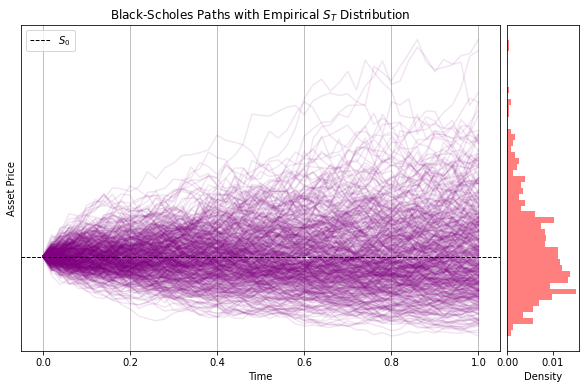

In [13]:
# Terminal prices
ST = paths[:, -1]

# Create figure
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot trajectories
time = np.linspace(0, T, n_steps+1)

for path in paths:
    ax1.plot(time, path, color='purple', alpha=0.1)

# Plot horizontal line at S0
ax1.axhline(S0, color='black', linestyle='--', linewidth=1, label='$S_0$')

ax1.set_xlabel("Time")
ax1.set_ylabel("Asset Price")
ax1.set_title("Black-Scholes Paths with Empirical $S_T$ Distribution")
ax1.grid(True)

# Create a new axis on the right for the histogram
divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size="15%", pad=0.1, sharey=ax1)

# Plot histogram vertically (right side)
ax2.hist(ST, bins=50, orientation='horizontal', color='red', alpha=0.5, density=True)
ax2.set_xlabel("Density")
ax2.set_yticks([])

ax1.legend()
plt.show()

## 5. Exotic Option Pricing via Monte Carlo

In this section, we discuss how to **price exotic options** using **Monte Carlo simulation**.  

### What are Exotic Options?

Exotic options are derivatives whose **payoffs are more complex** than standard European option contracts. Let's define their payoffs.

- **Barrier options**: Options that activate or extinguish if the underlying asset crosses a certain barrier.  

  - **Up-and-In Call:** 
  $$P = \mathbf{1}_{\{\max_{t \in [0,T]} S_t \ge H\}} \cdot \max(S_T - K, 0)$$

  where $H$ is the barrier level, $K$ the strike price, and $\mathbf{1}_{\{\cdot\}}$ the indicator function.


- **Asian options**: Options whose payoff depends on the average price of the underlying over a period.  

  - **Arithmetic Average Price Call:**  
    $$\text{Payoff} = \max\left(\frac{1}{M} \sum_{j=1}^M S_{t_j} - K, 0\right)$$  

  where $M$ is the number of averaging dates.


- **Lookback options**: Options that depend on the maximum or minimum asset price during the option’s life.  

  - **Fixed Strike Lookback Call:**  
    $$\text{Payoff} = \max\left(\max_{t \in [0,T]} S_t - K, 0\right)$$  

  - **Floating Strike Lookback Call:**  
    $$\text{Payoff} = \max_{t \in [0,T]} S_t - S_T$$  

The general idea is that the payoff of an exotic option can often be expressed as a function of the underlying asset path.

$$f(S_{t_0}, \dots, S_T)$$  


### Monte Carlo Simulation

Monte Carlo methods are **numerical techniques that estimate expectations by random sampling**.  


#### Example: Estimating the Expectation of a Random Variable

Suppose \(X\) is a random variable and we want to compute $E[X]$.  
If we can draw \(N\) independent samples $X_1, \dots, X_N \sim X$, then the Monte Carlo estimator of the expectation is:

$$
E[X] \approx \frac{1}{N} \sum_{i=1}^N X_i
$$

For instance, if $X \sim \text{U}(0,1)$, generating 1,000 samples and averaging them gives an estimate close to 0.5. "Close" actually means that the estimation has a certain probability of falling within an interval of confidence.


### Monte Carlo Convergence

Monte Carlo methods rely on the **Law of Large Numbers**:

> As the number of simulations $N$ increases, the sample average converges to the true expected value.

If $X_1, X_2, \dots, X_N$ are i.i.d. samples from a distribution with mean $\mu$ and variance $\sigma^2$, then:

$\hat{\mu}_N = \frac{1}{N} \sum_{i=1}^N X_i \quad \xrightarrow[N \to \infty]{} \quad \mu$

##### Key points:
- The $\textbf{variance}$ of the Monte Carlo estimator decreases as $1/N$.
- The $\textbf{standard error}$ (or $L_1$ error in expectation) of the estimator decreases as $1/\sqrt{N}$.
- Doubling accuracy requires **quadrupling** the number of simulations.
- By the **Central Limit Theorem**, for large $N$ the estimator is approximately normal:

  $\hat{\mu}_N \sim \mathcal{N}\Big(\mu, \frac{\sigma^2}{N}\Big)$

A **95% confidence interval** for $\mu$ can be expressed as an inequality:

$$\hat{\mu}_N - 1.96 \frac{\sigma}{\sqrt{N}} \le \mu \le \hat{\mu}_N + 1.96 \frac{\sigma}{\sqrt{N}}$$

This means that the true mean $\mu$ lies within this interval with approximately 95% probability.


**Example:** Let $X \sim U(0,1)$.  
The true mean is $0.5$. As we simulate many samples, the running average approaches $0.5$, and we can construct a confidence interval around the estimate to quantify the uncertainty.


#### In the context of option pricing:  

1. We simulate many possible paths of the underlying asset \(S_t\) under a chosen model (e.g., Black–Scholes).  
2. We compute the **payoff** of the exotic option for each simulated path.  
3. We take the **average discounted payoff** to estimate the option price:  

$$
V_0 \approx e^{-rT} \frac{1}{N} \sum_{i=1}^N f(S^{(i)}_{t_0}, \dots, S^{(i)}_T)
$$

where:  
- $N$ is the number of simulated paths,  
- $S^{(i)}_t$ is the \(i\)-th simulated trajectory of the underlying asset,  
- $f(\cdot)$ is the payoff function of the exotic option.  

Monte Carlo is especially useful for exotic options **where closed-form solutions are not available**, or for options with path-dependent payoffs.

In [14]:
def barrier_up_and_out_call_payoff(path: np.array, strike: float, barrier: float):
    """
    Up-and-Out Barrier Call option payoff:
    Pays max(S_T - K, 0) only if the barrier is never crossed upwards.
    
    Parameters:
    -----------
    path: Simulated asset price path
    strike: Strike price
    barrier: Barrier level
        
    Returns:
    --------
    Payoff at maturity
    """
    if np.any(path >= barrier):
        return 0
    else:
        return max(path[-1] - strike, 0)


def asian_call_payoff(path: np.array, strike: float):
    """
    Asian Call option payoff:
    Depends on the average price over the life of the option.
    
    Parameters:
    -----------
    path: Simulated asset price path
    K: Strike price
        
    Returns:
    --------
    Payoff at maturity
    """
    average_price = np.mean(path)
    
    return max(average_price - strike, 0)


def lookback_call_payoff(path):
    """
    Lookback Call option payoff:
    Depends on the maximum price reached over the life of the option.
    
    Parameters:
    -----------
    path: Simulated asset price path
        
    Returns:
    --------
    Payoff at maturity
    """
    return max(np.max(path) - path[0], 0)

In [15]:
def monte_carlo_option_price(
    payoff_func, 
    S0: float, 
    r: float,
    sigma: float,
    T: float, 
    n_steps: int,
    n_paths: int, 
    **kwargs):
    """
    Price an option using Monte Carlo simulation
    
    Parameters:
    -----------
    payoff_func: A function that computes the payoff given a simulated path.
    S0: Initial price of the underlying asset.
    r: Risk-free interest rate.
    sigma: Volatility of the underlying asset.
    T: Time to maturity.
    n_steps: Number of time steps in each path.
    n_paths: Number of simulated paths.
    kwargs: Arguments to pass to the payoff function (e.g., K, barrier).
    
    Returns:
    --------
    Monte Carlo estimate of the discounted option price.
    """
    payoffs = []
    
    for _ in range(n_paths):
        path = black_scholes_single_path(S0, r, sigma, T, n_steps)
        payoffs.append(payoff_func(path, **kwargs))
    
    # Computing the discounted average payoff
    discounted_payoff = np.exp(-r * T) * np.mean(payoffs)
    
    return discounted_payoff

In [16]:
# Trying out pricing functions

# Parameters
barrier = 120
strike = 100

n_steps = 100
n_paths = 1000

# Barrier Up-and-Out Call
price_barrier = monte_carlo_option_price(payoff_func=barrier_up_and_out_call_payoff, 
                                         S0=S0,
                                         r=r, 
                                         sigma=sigma, 
                                         T=T, 
                                         n_steps=n_steps, 
                                         n_paths=n_paths,
                                         strike=strike,
                                         barrier=barrier)

print("Barrier Up-and-Out Call Price:", price_barrier)

# Asian Call
price_asian = monte_carlo_option_price(payoff_func=asian_call_payoff,
                                       S0=S0, 
                                       r=r, 
                                       sigma=sigma,
                                       T=T, 
                                       n_steps=n_steps, 
                                       n_paths=n_paths, 
                                       strike=strike)

print("Asian Call Price:", price_asian)

# Lookback Call
price_lookback = monte_carlo_option_price(payoff_func=lookback_call_payoff,
                                          S0=S0,
                                          r=r, 
                                          sigma=sigma,
                                          T=T, 
                                          n_steps=n_steps, 
                                          n_paths=n_paths)

print("Lookback Call Price:", price_lookback)


Barrier Up-and-Out Call Price: 0.35904382363231085
Asian Call Price: 9.117620355748764
Lookback Call Price: 29.558093602029047


In [17]:
# Parameters
n_steps = 500
n_paths = 200

# Strike range
strikes = np.linspace(30, 170, 35)

# Compute option prices
asian_prices = [monte_carlo_option_price(payoff_func=asian_call_payoff,
                                         S0=S0, 
                                         r=r,
                                         sigma=sigma, 
                                         T=T, 
                                         n_steps=n_steps,
                                         n_paths=n_paths, 
                                         strike=strike) for strike in strikes]

asian_no_vol = [monte_carlo_option_price(payoff_func=asian_call_payoff,
                                         S0=S0, 
                                         r=r,
                                         sigma=0, 
                                         T=T, 
                                         n_steps=n_steps,
                                         n_paths=n_paths, 
                                         strike=strike) for strike in strikes]

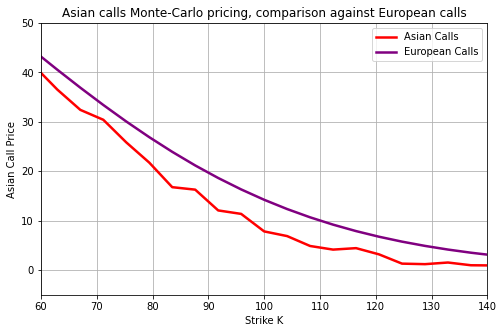

In [18]:
# Plotting the asian option prices against European prices

plt.figure(figsize=(8,5))
plt.plot(strikes, asian_prices, color='red', linewidth=2.5, label='Asian Calls')
plt.plot(strikes, call_prices, color='purple', linewidth=2.5, label='European Calls')
plt.xlabel("Strike K")
plt.ylabel("Asian Call Price")
plt.xlim(60, 140)
plt.ylim(-5, 50)
plt.title("Asian calls Monte-Carlo pricing, comparison against European calls")
plt.legend()
plt.grid()
plt.show()

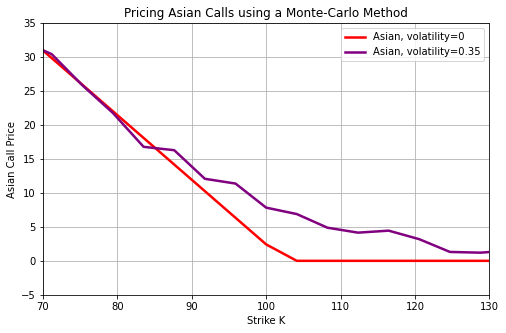

In [19]:
# Plotting the two curves of Asian options under regular volatility or no volatility conditions

plt.figure(figsize=(8,5))
plt.plot(strikes, asian_no_vol, color='red', linewidth=2.5, label='Asian, volatility=0')
plt.plot(strikes, asian_prices, color='purple', linewidth=2.5, label=f'Asian, volatility={sigma}')
plt.xlabel("Strike K")
plt.ylabel("Asian Call Price")
plt.title("Pricing Asian Calls using a Monte-Carlo Method")
plt.legend()
plt.xlim(70, 130)
plt.ylim(-5, 35)
plt.grid()
plt.show()

### Why an Asian Call is Cheaper than a European Call — and Why the Gap Shrinks with Volatility

#### 1) Pricing intuition (risk-neutral world)

Under risk-neutral pricing, we value options as discounted expectations:
- European call (strike $K$): $C^{\mathrm{Eur}} = e^{-rT}\,E[(S_T - K)^+]$
- Discrete-time Asian call (arithmetic average $\bar S = \frac{1}{n}\sum_{i=1}^n S_{t_i}$):  
  $C^{\mathrm{Asian}} = e^{-rT}\,E[(\bar S - K)^+]$

Two structural facts make the Asian call cheaper:

**(a) Lower expectancy of the average**  
Under the risk-neutral measure, $E[S_t]=S_0 e^{rt}$. Hence
$$
E[\bar S] \;=\; \frac{1}{n}\sum_{i=1}^n E[S_{t_i}]
\;<\; E[S_T] \;=\; S_0 e^{rT}\quad\text{(for } r>0\text{)}.
$$
So, on average, the Asian’s underlying ($\bar S$) sits below the European’s underlying ($S_T$).

**(b) Lower variance (time-averaging smooths noise).**  
A time average has smaller variance than a single endpoint of the same stochastic process. Since the call payoff $x\mapsto (x-K)^+$ is convex and increasing, a higher-variance underlying (with comparable mean) yields a higher expected payoff (convexity effect). Therefore, with less variance, the Asian call loses value relative to the European call.

Combining (a) and (b) gives:
$$
C^{\mathrm{Asian}} \;\leq\; C^{\mathrm{Eur}}.
$$

---

#### 2) Why the price gap shrinks as volatility $\sigma$ increases

As $\sigma$ increases (with fixed $T$):

- **European call:** Its payoff depends only on the terminal value $S_T$. Higher volatility increases the spread of possible $S_T$ values, creating more chances for very large payoffs $(S_T - K)^+$.  

- **Asian call:** Although averaging dampens fluctuations, higher volatility also increases the spread of the *average price* $\bar S$. When $\sigma$ is very large, the average can still deviate far above $K$ for a substantial fraction of simulated paths, because large swings in $S_t$ happen frequently throughout the life of the option — not just near maturity.  

- **Why the gap closes:** At low or moderate volatility, averaging significantly reduces payoff variance, making the Asian option cheaper. But when volatility is extreme, prices along the whole path vary so widely that the average and the terminal price become similarly “far” from $K$ in distribution. In the limit of huge $\sigma$, both payoffs grow at comparable rates, so:
$$
C^{\mathrm{Eur}} - C^{\mathrm{Asian}} \to 0 \quad \text{as } \sigma \to \infty.
$$

Two bounding/limit heuristics help explain the shrinking gap:

**(1) Upper bound by the spot $S_0$.**  
For a non-dividend-paying asset in Black–Scholes, the no-arbitrage price of any nonnegative payoff is bounded above by $S_0$ (intuitively, you cannot pay more than the asset itself). As $\sigma \to \infty$, the European call price approaches this upper bound, and the Asian call is dragged upward as well.

**(2) Tail dominance reduces the averaging penalty.**  
At moderate $\sigma$, averaging “dampens” upside relative to $S_T$, creating a noticeable discount for the Asian call. But as $\sigma$ becomes very large, paths that produce large $S_T$ typically also produce very large values close to $T$, which spill into the average and erode the discount. In the extreme-volatility regime, both prices are dominated by the same explosive tail behavior, so
$$
C^{\mathrm{Eur}} - C^{\mathrm{Asian}} \;\to\; 0 \quad \text{as } \sigma \to \infty.
$$